# Independent multi-series forecasting


In [univariate time series forecasting](https://skforecast.org/latest/introduction-forecasting/introduction-forecasting.html), a single time series is modeled as a linear or nonlinear combination of its lags, where past values of the series are used to forecast its future. In multi-series forecasting, two or more time series are modeled together using a single model.


In **independent multi-series forecasting** a single model is trained for all time series, but each time series remains independent of the others, meaning that past values of one series are not used as predictors of other series. However, modeling them together is useful because the series may follow the same intrinsic pattern regarding their past and future values. For instance, the sales of products A and B in the same store may not be related, but they follow the same dynamics, that of the store.

<p style="text-align: center">
<img src="../img/forecaster_multi_series_train_matrix_diagram.png" style="width: 700px">
<br>
<font size="2.5"> <i>Internal Forecaster transformation of two time series and an exogenous variable into the matrices needed to train a machine learning model in a multi-series context.</i></font>
</p>

To predict the next *n* steps, the strategy of [recursive multi-step forecasting](https://skforecast.org/latest/introduction-forecasting/introduction-forecasting.html#recursive-multi-step-forecasting) is applied, with the only difference being that the series name for which to estimate the predictions needs to be indicated.

<p style="text-align: center">
<img src="../img/forecaster_multi_series_prediction_diagram.png" style="width: 700px">
<br>
<font size="2.5"> <i>Diagram of recursive forecasting with multiple independent time series.</i></font>
</p>

Using the `ForecasterAutoregMultiSeries` and `ForecasterAutoregMultiSeriesCustom` classes, it is possible to easily build machine learning models for independent multi-series forecasting.

<script src="https://kit.fontawesome.com/d20edc211b.js" crossorigin="anonymous"></script>

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px;
border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px;">
<p class="title">
    <i class="fa-solid fa-fire-flame-curved" style="font-size: 18px; color:#00bfa5;"></i>
    <b> &nbsp Tip</b>
</p>

To learn more about independent multi-series forecasting visit our example: <a href="https://www.cienciadedatos.net/documentos/py44-multi-series-forecasting-skforecast.html">Multi-series forecasting with Python and Skforecast</a>.

</div>

<script src="https://kit.fontawesome.com/d20edc211b.js" crossorigin="anonymous"></script>

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px;
border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px;">
<p class="title">
    <i class="fa-light fa-pencil fa" style="font-size: 18px; color:#00b8d4;"></i>
    <b> &nbsp Note</b>
</p>

See <a href="https://skforecast.org/latest/user_guides/dependent-multi-series-multivariate-forecasting.html">ForecasterAutoregMultiVariate</a> for dependent multi-series forecasting (multivariate time series).

</div>

## Libraries

In [1]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries

## Data

In [2]:
# Data download
# ==============================================================================
url = (
       'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/'
       'data/simulated_items_sales.csv'
)
data = pd.read_csv(url, sep=',')

# Data preparation
# ==============================================================================
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('D')
data = data.sort_index()
data.head()

item_1     item_2     item_3
date                                       
2012-01-01   8.253175  21.047727  19.429739
2012-01-02  22.777826  26.578125  28.009863
2012-01-03  27.549099  31.751042  32.078922
2012-01-04  25.895533  24.567708  27.252276
2012-01-05  21.379238  18.191667  20.357737

In [3]:
# Split data into train-val-test
# ==============================================================================
end_train = '2014-07-15 23:59:00'
data_train = data.loc[:end_train, :].copy()
data_test  = data.loc[end_train:, :].copy()

print(
    f"Train dates : {data_train.index.min()} --- {data_train.index.max()}   "
    f"(n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}   "
    f"(n={len(data_test)})"
)

Train dates : 2012-01-01 00:00:00 --- 2014-07-15 00:00:00   (n=927)
Test dates  : 2014-07-16 00:00:00 --- 2015-01-01 00:00:00   (n=170)


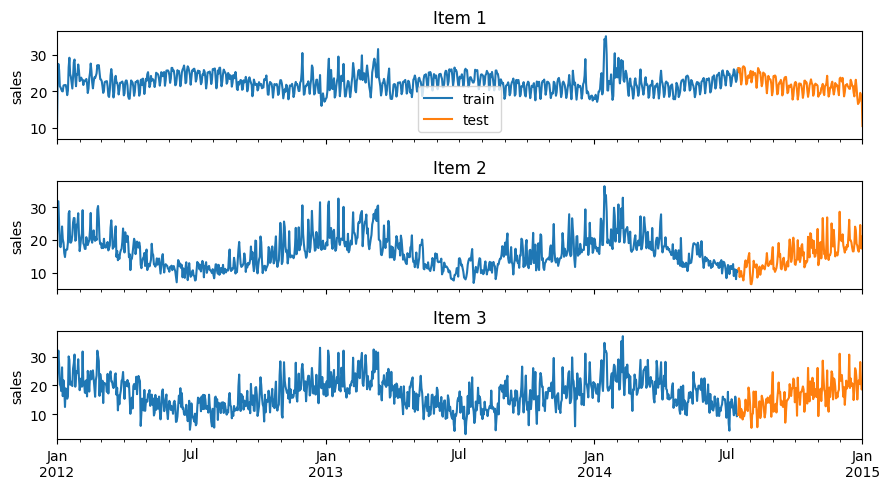

In [4]:
# Plot time series
# ==============================================================================
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(9, 5), sharex=True)

data_train['item_1'].plot(label='train', ax=axes[0])
data_test['item_1'].plot(label='test', ax=axes[0])
axes[0].set_xlabel('')
axes[0].set_ylabel('sales')
axes[0].set_title('Item 1')
axes[0].legend()

data_train['item_2'].plot(label='train', ax=axes[1])
data_test['item_2'].plot(label='test', ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('sales')
axes[1].set_title('Item 2')

data_train['item_3'].plot(label='train', ax=axes[2])
data_test['item_3'].plot(label='test', ax=axes[2])
axes[2].set_xlabel('')
axes[2].set_ylabel('sales')
axes[2].set_title('Item 3')

fig.tight_layout()
plt.show();

## Train and predict ForecasterAutoregMultiSeries

In [5]:
# Create and fit forecaster multi series
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = Ridge(random_state=123),
                 lags               = 24,
                 transformer_series = None,
                 transformer_exog   = None,
                 weight_func        = None,
                 series_weights     = None,
                 forecaster_id      = None
             )

forecaster.fit(series=data_train)
forecaster

ForecasterAutoregMultiSeries 
Regressor: Ridge(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for series: None 
Transformer for exog: None 
Window size: 24 
Series levels (names): ['item_1', 'item_2', 'item_3'] 
Series weights: None 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2012-01-01 00:00:00'), Timestamp('2014-07-15 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': 123, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2023-09-09 17:01:38 
Last fit date: 2023-09-09 17:01:38 
Skforecast version: 0.10.0 
Python version: 3.10.11 
Forecaster id: None 

Two methods can be use to predict the next n steps: `predict()` or `predict_interval()`. The argument `levels` is used to indicate for which series estimate predictions. If `None` all series will be predicted.

In [6]:
# Predict and predict_interval
# ==============================================================================
steps = 24

# Predictions for item_1
predictions_item_1 = forecaster.predict(steps=steps, levels='item_1')
display(predictions_item_1.head(3))

# Interval predictions for item_1 and item_2
predictions_intervals = forecaster.predict_interval(steps=steps, levels=['item_1', 'item_2'])
display(predictions_intervals.head(3))

item_1
2014-07-16  25.497376
2014-07-17  24.866972
2014-07-18  24.281173

item_1  item_1_lower_bound  item_1_upper_bound     item_2  \
2014-07-16  25.497376           23.220087           28.226068  10.694506   
2014-07-17  24.866972           22.141168           27.389805  11.080091   
2014-07-18  24.281173           21.688393           26.981395  11.490882   

            item_2_lower_bound  item_2_upper_bound  
2014-07-16            7.093046           15.518896  
2014-07-17            6.467676           16.534679  
2014-07-18            7.077863           16.762530

## Backtesting Multi Series

As in the `predict` method, the `levels` at which [backtesting](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/backtesting.html) is performed must be indicated. The argument can also be set to `None` to perform backtesting at all levels.

In [7]:
# Backtesting Multi Series
# ==============================================================================
metrics_levels, backtest_predictions = backtesting_forecaster_multiseries(
                                           forecaster            = forecaster,
                                           series                = data,
                                           exog                  = None,
                                           levels                = None,
                                           steps                 = 24,
                                           metric                = 'mean_absolute_error',
                                           initial_train_size    = len(data_train),
                                           fixed_train_size      = True,
                                           gap                   = 0,
                                           allow_incomplete_fold = True,
                                           refit                 = True,
                                           n_jobs                = 'auto',
                                           verbose               = False,
                                           show_progress         = True
                                       )

print("Backtest metrics")
display(metrics_levels)
print("")
print("Backtest predictions")
backtest_predictions.head(4)

  0%|          | 0/8 [00:00<?, ?it/s]

Backtest metrics


levels  mean_absolute_error
0  item_1             1.360675
1  item_2             2.332392
2  item_3             3.155592


Backtest predictions


item_1     item_2     item_3
2014-07-16  25.497376  10.694506  11.275026
2014-07-17  24.866972  11.080091  11.313510
2014-07-18  24.281173  11.490882  13.030112
2014-07-19  23.515499  11.548922  13.378282

## Hyperparameter tuning and lags selection Multi Series

The `grid_search_forecaster_multiseries` and `random_search_forecaster_multiseries` functions in the `model_selection_multiseries` module allow for lag and hyperparameter optimization. The optimization is performed using the same strategy as in other Forecasters, [see the user guide here](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/hyperparameter-tuning-and-lags-selection.html), except for the `levels` argument:

+ `levels`: level(s) at which the forecaster is optimized, for example:

    + If `levels = ['item_1', 'item_2', 'item_3']` (Same as `levels = None`), the function will search for the lags and hyperparameters that minimize the average error of the predictions of all the time series. The resulting metric will be the **average of all levels**. 

    + If `levels = 'item_1'` (Same as `levels = ['item_1']`), the function will search for the lags and hyperparameters that minimize the error of the `item_1` predictions. The resulting metric will be the one calculated for `item_1`.

The following example shows how to use `grid_search_forecaster_multiseries` to find the best lags and model hyperparameters for all time series (all `levels`):

In [8]:
# Create Forecaster multi series
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = Ridge(random_state=123),
                 lags               = 24,
                 transformer_series = StandardScaler(),
                 transformer_exog   = None,
                 weight_func        = None,
                 series_weights     = None
             )

In [9]:
# Grid search Multi Series
# ==============================================================================
lags_grid = [24, 48]
param_grid = {'alpha': [0.01, 0.1, 1]}

levels = ['item_1', 'item_2', 'item_3']

results = grid_search_forecaster_multiseries(
              forecaster         = forecaster,
              series             = data,
              exog               = None,
              levels             = levels, # Same as levels=None
              lags_grid          = lags_grid,
              param_grid         = param_grid,
              steps              = 24,
              metric             = 'mean_absolute_error',
              initial_train_size = len(data_train),
              refit              = True,
              fixed_train_size   = True,
              return_best        = False,
              n_jobs             = 'auto',
              verbose            = False,
              show_progress      = True
          )

results

6 models compared for 3 level(s). Number of iterations: 6.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/3 [00:00<?, ?it/s]

levels  \
5  [item_1, item_2, item_3]   
4  [item_1, item_2, item_3]   
3  [item_1, item_2, item_3]   
2  [item_1, item_2, item_3]   
1  [item_1, item_2, item_3]   
0  [item_1, item_2, item_3]   

                                                lags           params  \
5  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...     {'alpha': 1}   
4  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   {'alpha': 0.1}   
3  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  {'alpha': 0.01}   
2  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...     {'alpha': 1}   
1  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   {'alpha': 0.1}   
0  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  {'alpha': 0.01}   

   mean_absolute_error  alpha  
5             2.207648   1.00  
4             2.207700   0.10  
3             2.207706   0.01  
2             2.335039   1.00  
1             2.335149   0.10  
0             2.335161   0.01

## Exogenous variables in multi-series

Exogenous variables are predictors that are independent of the model being used for forecasting, and their future values must be known in order to include them in the prediction process.

In the `ForecasterAutoregMultiSeries`, the same exogenous variables are replicated for each of the series. Here is an example of adding the month of the series as an exogenous variable.

<script src="https://kit.fontawesome.com/d20edc211b.js" crossorigin="anonymous"></script>

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px;
border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px;">
<p class="title">
    <i class="fa-solid fa-fire-flame-curved" style="font-size: 18px; color:#00bfa5;"></i>
    <b> &nbsp Tip</b>
</p>

To learn more about exogenous variables in skforecast visit the <a href="https://skforecast.org/latest/user_guides/exogenous-variables">exogenous variables user guide</a>.

</div>

In [10]:
# Generate exogenous variable month
# ==============================================================================
data_exog = data.copy()
data_exog['month'] = data_exog.index.month

# Split data into train-val-test
# ==============================================================================
end_train = '2014-07-15 23:59:00'
data_exog_train = data_exog.loc[:end_train, :].copy()
data_exog_test  = data_exog.loc[end_train:, :].copy()

data_exog_train.head(3)

item_1     item_2     item_3  month
date                                              
2012-01-01   8.253175  21.047727  19.429739      1
2012-01-02  22.777826  26.578125  28.009863      1
2012-01-03  27.549099  31.751042  32.078922      1

In [11]:
# Create and fit forecaster multi series
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor = Ridge(random_state=123),
                 lags      = 24,
             )

forecaster.fit(
    series = data_exog_train[['item_1', 'item_2', 'item_3']], 
    exog   = data_exog_train[['month']]
)
forecaster

ForecasterAutoregMultiSeries 
Regressor: Ridge(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for series: None 
Transformer for exog: None 
Window size: 24 
Series levels (names): ['item_1', 'item_2', 'item_3'] 
Series weights: None 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['month'] 
Training range: [Timestamp('2012-01-01 00:00:00'), Timestamp('2014-07-15 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': 123, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2023-09-09 17:01:42 
Last fit date: 2023-09-09 17:01:42 
Skforecast version: 0.10.0 
Python version: 3.10.11 
Forecaster id: None 

If the `Forecaster` has been trained using exogenous variables, they should be provided during the prediction phase.

In [12]:
# Predict with exogenous variables
# ==============================================================================
predictions = forecaster.predict(steps=24, exog=data_exog_test[['month']])
predictions.head(3)

item_1     item_2     item_3
2014-07-16  25.493029  10.698000  11.278556
2014-07-17  24.860186  11.085074  11.318098
2014-07-18  24.273013  11.497196  13.035015

As mentioned earlier, the `month` exogenous variable is replicated for each of the series. This can be easily demonstrated using the `create_train_X_y` method, which returns the matrix used in the `fit` method.

In [13]:
# X_train matrix
# ==============================================================================
X_train = forecaster.create_train_X_y(
    series = data_exog_train[['item_1', 'item_2', 'item_3']], 
    exog   = data_exog_train[['month']]
)[0]

In [14]:
# X_train slice for item_1
# ==============================================================================
X_train.loc[X_train['item_1'] == 1.].head(3)

lag_1      lag_2      lag_3      lag_4      lag_5      lag_6  \
0  28.018830  23.981037  20.794986  22.503533  24.018768  24.772249   
1  28.747482  28.018830  23.981037  20.794986  22.503533  24.018768   
2  23.908368  28.747482  28.018830  23.981037  20.794986  22.503533   

       lag_7      lag_8      lag_9     lag_10  ...     lag_19     lag_20  \
0  29.245869  26.636444  20.228468  18.976196  ...  21.106643  21.379238   
1  24.772249  29.245869  26.636444  20.228468  ...  20.533871  21.106643   
2  24.018768  24.772249  29.245869  26.636444  ...  20.069327  20.533871   

      lag_21     lag_22     lag_23     lag_24  month  item_1  item_2  item_3  
0  25.895533  27.549099  22.777826   8.253175      1     1.0     0.0     0.0  
1  21.379238  25.895533  27.549099  22.777826      1     1.0     0.0     0.0  
2  21.106643  21.379238  25.895533  27.549099      1     1.0     0.0     0.0  

[3 rows x 28 columns]

In [15]:
# X_train slice for item_2
# ==============================================================================
X_train.loc[X_train['item_2'] == 1.].head(3)

lag_1      lag_2      lag_3      lag_4      lag_5      lag_6  \
903  26.675000  25.332292  21.690625  19.688542  19.178125  19.265625   
904  26.611458  26.675000  25.332292  21.690625  19.688542  19.178125   
905  19.759375  26.611458  26.675000  25.332292  21.690625  19.688542   

         lag_7      lag_8      lag_9     lag_10  ...     lag_19     lag_20  \
903  28.779167  28.060417  19.255208  17.096875  ...  17.812500  18.191667   
904  19.265625  28.779167  28.060417  19.255208  ...  19.510417  17.812500   
905  19.178125  19.265625  28.779167  28.060417  ...  24.098958  19.510417   

        lag_21     lag_22     lag_23     lag_24  month  item_1  item_2  item_3  
903  24.567708  31.751042  26.578125  21.047727      1     0.0     1.0     0.0  
904  18.191667  24.567708  31.751042  26.578125      1     0.0     1.0     0.0  
905  17.812500  18.191667  24.567708  31.751042      1     0.0     1.0     0.0  

[3 rows x 28 columns]

To use exogenous variables in backtesting or hyperparameter tuning, they must be specified with the `exog` argument.

In [16]:
# Backtesting Multi Series with exog
# ==============================================================================
metrics_levels, backtest_predictions = backtesting_forecaster_multiseries(
                                           forecaster            = forecaster,
                                           series                = data_exog[['item_1', 'item_2', 'item_3']],
                                           exog                  = data_exog[['month']],
                                           levels                = None,
                                           steps                 = 24,
                                           metric                = 'mean_absolute_error',
                                           initial_train_size    = len(data_exog_train),
                                           fixed_train_size      = True,
                                           gap                   = 0,
                                           allow_incomplete_fold = True,
                                           refit                 = True,
                                           n_jobs                = 'auto',
                                           verbose               = False,
                                           show_progress         = True
                                       )

print("Backtest metrics")
display(metrics_levels)
print("")
print("Backtest predictions with exogenous variables")
backtest_predictions.head(4)

  0%|          | 0/8 [00:00<?, ?it/s]

Backtest metrics


levels  mean_absolute_error
0  item_1             1.368685
1  item_2             2.335076
2  item_3             3.152820


Backtest predictions with exogenous variables


item_1     item_2     item_3
2014-07-16  25.493029  10.698000  11.278556
2014-07-17  24.860186  11.085074  11.318098
2014-07-18  24.273013  11.497196  13.035015
2014-07-19  23.506739  11.555868  13.383641

## Scikit-learn transformers in multi-series

Learn more about [using scikit-learn transformers](https://skforecast.org/latest/user_guides/sklearn-transformers-and-pipeline.html) with skforecast.

+  If `transformer_series` is a `transformer` the same transformation will be applied to all series. 
+  If `transformer_series` is a `dict` a different transformation can be set for each series. Series not present in the dict will not have any transformation applied to them.

In [17]:
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = Ridge(random_state=123),
                 lags               = 24,
                 transformer_series = {'item_1': StandardScaler(), 'item_2': StandardScaler()},
                 transformer_exog   = None,
                 weight_func        = None,
                 series_weights     = None
             )

forecaster.fit(series=data_train)
forecaster

c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:420: IgnoredArgumentWarning: {'item_3'} not present in `transformer_series`. No transformation is applied to these series. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=IgnoredArgumentWarning)
  warnings.warn(


ForecasterAutoregMultiSeries 
Regressor: Ridge(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for series: {'item_1': StandardScaler(), 'item_2': StandardScaler()} 
Transformer for exog: None 
Window size: 24 
Series levels (names): ['item_1', 'item_2', 'item_3'] 
Series weights: None 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2012-01-01 00:00:00'), Timestamp('2014-07-15 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': 123, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2023-09-09 17:01:43 
Last fit date: 2023-09-09 17:01:43 
Skforecast version: 0.10.0 
Python version: 3.10.11 
Forecaster id: None 

## Series with different lengths

When faced with a multi-series forecasting problem, it is common for the series to have varying lengths due to differences in the starting times of data recording. To address this scenario, the `ForecasterAutoregMultiSeries` provides a solution taking into account the following points:

- The input for the `series` parameter must be a **pandas DataFrame** containing all series where missing values must be represented as `NaNs`.
- Missing values are only expected to occur at the beginning of each series.
- All series should conclude at the same index and possess a length greater than or equal to the maximum lag used.

Examples:

| Series values                            | Allowed |
|:-----------------------------------------|:-------:|
| `[NaN, NaN, NaN, NaN, 4, 5, 6, 7, 8, 9]` |✔️       |
| `[0, 1, 2, 3, 4, 5, 6, 7, 8, NaN]`       |❌       |
| `[0, 1, 2, 3, 4, NaN, 6, 7, 8, 9]`       |❌       |
| `[NaN, NaN, 2, 3, 4, NaN, 6, 7, 8, 9]`   |❌       |


In [18]:
# Create NaNs in columns `item_2` and `item_3` 
# ==============================================================================
data_train_with_nan = data_train.copy()
data_train_with_nan['item_2'].iloc[:300] = np.nan
data_train_with_nan['item_3'].iloc[:500] = np.nan

print('Data train shape:', data_train_with_nan.shape)
data_train_with_nan.isna().sum()

Data train shape: (927, 3)


item_1      0
item_2    300
item_3    500
dtype: int64

In [19]:
# Create and fit forecaster multi series
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = Ridge(random_state=123),
                 lags               = 24,
                 transformer_series = StandardScaler(),
                 transformer_exog   = None,
                 weight_func        = None,
                 series_weights     = None
             )

forecaster.fit(series=data_train)

In [20]:
# Predict all levels
# ==============================================================================
predictions = forecaster.predict(steps=24)
predictions.head(3)

item_1     item_2     item_3
2014-07-16  25.864018  10.742220  11.569140
2014-07-17  25.229255  11.151981  10.844131
2014-07-18  24.584602  11.662202  12.608430

When creating the **training matrix**, the forecaster will use a different number of observations depending on the length of the series. This number can be calculated as: $SeriesLength - LengthMissing - MaxLag$

In [21]:
# Understanding training matrix
# ==============================================================================
X_train = forecaster.create_train_X_y(data_train_with_nan)[0]

# Data train shape
print('Data train shape:', data_train_with_nan.shape)
print('Max lag used:', forecaster.max_lag)
print("")

# Determine the number of observations per series
len_1 = len(X_train.loc[X_train['item_1'] == 1.])
len_2 = len(X_train.loc[X_train['item_2'] == 1.])
len_3 = len(X_train.loc[X_train['item_3'] == 1.])

print("X_train shape:", X_train.shape)
print('item_1 length:', len_1) # 927 - 24
print('item_2 length:', len_2) # 927 - 300 - 24
print('item_3 length:', len_3) # 927 - 500 - 24
print("Total length:", len_1 + len_2 + len_3)

Data train shape: (927, 3)
Max lag used: 24

X_train shape: (1909, 27)
item_1 length: 903
item_2 length: 603
item_3 length: 403
Total length: 1909


## Weights in multi-series

The weights are used to control the influence that each observation has on the training of the model. `ForecasterAutoregMultiseries` accepts two types of weights:

+ `series_weights` controls the relative importance of each series. If a series has twice as much weight as the others, the observations of that series influence the training twice as much. The higher the weight of a series relative to the others, the more the model will focus on trying to learn that series.

+ `weight_func` controls the relative importance of each observation according to its index value. For example, a function that assigns a lower weight to certain dates.

If the two types of weights are indicated, they are **multiplied to create the final weights**. The resulting `sample_weight` cannot have negative values.

<p style="text-align: center">
<img src="../img/forecaster_multi_series_sample_weight.png" style="width: 900px">
<br>
<font size="2.5"> <i>Weights in multi-series.</i></font>
</p>

+ `series_weights` is a dict of the form `{'series_column_name': float}`. If a series is used during `fit` and is not present in `series_weights`, it will have a weight of 1.

+ `weight_func` is a function that defines the individual weights of each sample **based on the index**. 
  
    + If it is a `callable`, the same function will apply to all series. 
  
    + If it is a `dict` of the form `{'series_column_name': callable}`, a different function can be used for each series. A weight of 1 is given to all series not present in `weight_func`.

In [22]:
# Weights in Multi-Series
# ==============================================================================
def custom_weights(index):
    """
    Return 0 if index is between '2013-01-01' and '2013-01-31', 1 otherwise.
    """
    weights = np.where(
                  (index >= '2013-01-01') & (index <= '2013-01-31'),
                   0,
                   1
              )
    
    return weights

forecaster = ForecasterAutoregMultiSeries(
                 regressor          = Ridge(random_state=123),
                 lags               = 24,
                 transformer_series = None,
                 transformer_exog   = None,
                 weight_func        = custom_weights,
                 series_weights     = {'item_1': 1., 'item_2': 2., 'item_3': 1.} # Same as {'item_2': 2.}
             )

forecaster.fit(series=data_train)
forecaster.predict(steps=24).head(3)

item_1     item_2     item_3
2014-07-16  25.547560  10.527454  11.195018
2014-07-17  24.779779  10.987891  11.424717
2014-07-18  24.182702  11.375158  13.090853

<script src="https://kit.fontawesome.com/d20edc211b.js" crossorigin="anonymous"></script>

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px;">
<p class="title">
    <i class="fa-triangle-exclamation fa" style="font-size: 18px; color:#ff9100;"></i>
    <b style="color: #ff9100;"> &nbsp Warning</b>
</p>

The <code>weight_func</code> and <code>series_weights</code> arguments will be ignored if the regressor does not accept <code>sample_weight</code> in its <code>fit</code> method.

</div>

The source code of the `weight_func` added to the forecaster is stored in the argument `source_code_weight_func`. If `weight_func` is a `dict`, it will be a `dict` of the form `{'series_column_name': source_code_weight_func}` .

In [23]:
print(forecaster.source_code_weight_func)

def custom_weights(index):
    """
    Return 0 if index is between '2013-01-01' and '2013-01-31', 1 otherwise.
    """
    weights = np.where(
                  (index >= '2013-01-01') & (index <= '2013-01-31'),
                   0,
                   1
              )
    
    return weights



## Compare multiple metrics

All three functions (`backtesting_forecaster_multiseries`, `grid_search_forecaster_multiseries`, and `random_search_forecaster_multiseries`) allow the calculation of multiple metrics for each forecaster configuration if a list is provided. This list may include custom metrics and the best model selection is done based on the first metric of the list.

In [24]:
# Grid search Multi-Series with multiple metrics
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = Ridge(random_state=123),
                 lags               = 24
             )

def custom_metric(y_true, y_pred):
    """
    Calculate the mean absolute error using only the predicted values of the last
    3 months of the year.
    """
    mask = y_true.index.month.isin([10, 11, 12])
    metric = mean_absolute_error(y_true[mask], y_pred[mask])
    
    return metric

lags_grid = [24, 48]
param_grid = {'alpha': [0.01, 0.1, 1]}

results = grid_search_forecaster_multiseries(
              forecaster         = forecaster,
              series             = data,
              lags_grid          = lags_grid,
              param_grid         = param_grid,
              steps              = 24,
              metric             = [mean_absolute_error, custom_metric, 'mean_squared_error'],
              initial_train_size = len(data_train),
              fixed_train_size   = True,
              levels             = None,
              exog               = None,
              refit              = True,
              return_best        = False,
              n_jobs             = 'auto',
              verbose            = False,
              show_progress      = True
          )

results

6 models compared for 3 level(s). Number of iterations: 6.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/3 [00:00<?, ?it/s]

levels  \
5  [item_1, item_2, item_3]   
4  [item_1, item_2, item_3]   
3  [item_1, item_2, item_3]   
2  [item_1, item_2, item_3]   
1  [item_1, item_2, item_3]   
0  [item_1, item_2, item_3]   

                                                lags           params  \
5  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...     {'alpha': 1}   
4  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   {'alpha': 0.1}   
3  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  {'alpha': 0.01}   
2  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...     {'alpha': 1}   
1  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   {'alpha': 0.1}   
0  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  {'alpha': 0.01}   

   mean_absolute_error  custom_metric  mean_squared_error  alpha  
5             2.190420       2.290771            9.250861   1.00  
4             2.190493       2.290853            9.251522   0.10  
3             2.190500       2.290861            9.251589   0.01  
2             2.282886       2.358415            9.770826   1.00  
1             2.282948       2.358494            9.771567   0.10  
0             2.282954       2.358502            9.771641   0.01

<script src="https://kit.fontawesome.com/d20edc211b.js" crossorigin="anonymous"></script>

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px;
border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px;">
<p class="title">
    <i class="fa-solid fa-fire-flame-curved" style="font-size: 18px; color:#00bfa5;"></i>
    <b> &nbsp Tip</b>
</p>

<code>bayesian_search_forecaster_multiseries</code> will be released in a future version of <b>skforecast</b>.

Stay tuned!

</div>

In [25]:
%%html
<style>
.jupyter-wrapper .jp-CodeCell .jp-Cell-inputWrapper .jp-InputPrompt {display: none;}
</style>